# Compare predictions
This notebook includes a comparison between the predictions of the hydroestimator, the cnn and the mlp on the rain gauge data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
import xarray as xr
import pandas as pd
import os
import datetime
import seaborn as sns

import cartopy
import cartopy.crs as ccrs
from pyresample import load_area, geometry

import quantnn

In [2]:
f = open('../path_to_data.txt', "r")
path_to_dataset = os.path.join(f.readline().rstrip("\n"))
f.close() 

In [3]:
combined = xr.open_dataset(os.path.join(path_to_dataset,'combined.nc'))

In [4]:
combined

<xarray.Dataset>
Dimensions:                  (location: 609, time: 738)
Coordinates:
  * location                 (location) int64 0 1 2 3 4 ... 604 605 606 607 608
  * time                     (time) datetime64[ns] 2020-12-01T01:00:00 ... 20...
Data variables:
    xception_posterior_mean  (time, location) float32 ...
    xception_Q0.95           (time, location) float32 ...
    xception_Q0.99           (time, location) float32 ...
    mlp_posterior_mean       (time, location) float32 ...
    mlp_Q0.95                (time, location) float32 ...
    mlp_Q0.99                (time, location) float32 ...
    HE_precip                (time, location) float64 ...
    HE_precip_corr           (time, location) float64 ...
    gauge_precip             (time, location) float64 ...

### Single rain gauge over time

391


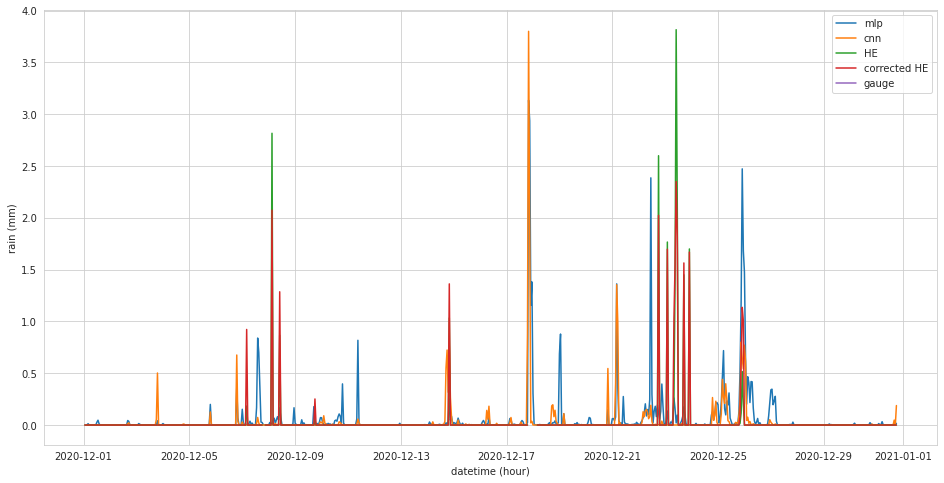

In [5]:
sns.set_style('whitegrid')
ind = 391 
print(ind)

fig, ax = plt.subplots(figsize=(16,8))
plt.plot(combined.time, combined.mlp_posterior_mean[:, ind], label='mlp')
plt.plot(combined.time, combined.xception_posterior_mean[:, ind], label='cnn')
plt.plot(combined.time, combined.HE_precip[:, ind], label='HE')
plt.plot(combined.time, combined.HE_precip_corr[:, ind], label='corrected HE')
plt.plot(combined.time, combined.gauge_precip[:, ind], label='gauge')

ax.set_ylabel('rain (mm)')
ax.set_xlabel('datetime (hour)')
ax.legend()

### Scalar metrics

In [6]:
np.nanmean(combined.gauge_precip-combined.HE_precip)

-0.10395083635324988

In [7]:
np.nanmean(combined.gauge_precip-combined.HE_precip_corr)

0.006716587598407625

In [8]:
np.nanmean(combined.gauge_precip-combined.xception_posterior_mean)

-0.004699792821834451

In [9]:
np.nanmean(combined.gauge_precip-combined.mlp_posterior_mean)

0.020730019446901587

In [10]:
np.nanmean(np.square(np.subtract(combined.gauge_precip.values, combined.HE_precip.values)))

3.940874754925588

In [11]:
np.nanmean(np.square(np.subtract(combined.gauge_precip.values, combined.HE_precip_corr.values)))

2.438601627897914

In [12]:
np.nanmean(np.square(np.subtract(combined.gauge_precip.values, combined.xception_posterior_mean.values)))

1.7017950619618283

In [13]:
np.nanmean(np.square(np.subtract(combined.gauge_precip.values, combined.mlp_posterior_mean.values)))

2.0412893711302513

# ....

Text(0, 0.5, 'time')

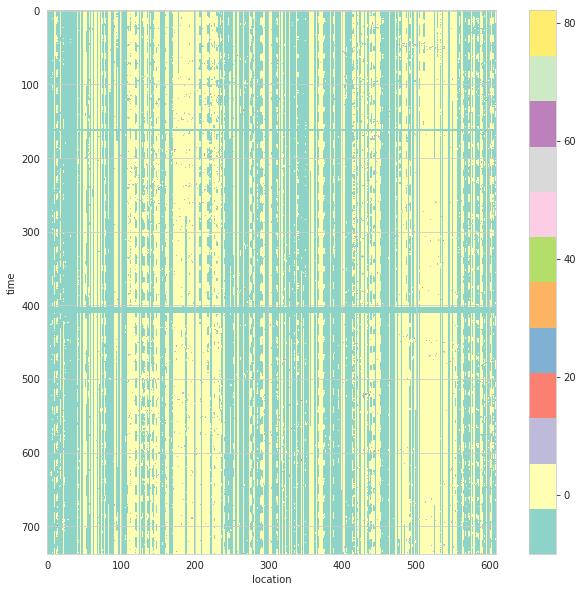

In [14]:
fig, ax = plt.subplots(figsize = (12,10))
data = np.abs(combined.gauge_precip-combined.HE_precip_corr).values
data[np.isnan(data)] = -10
m = ax.imshow(data, cmap='Set3')
fig.colorbar(m)
ax.set_xlabel('location')
ax.set_ylabel('time')

### Histograms 

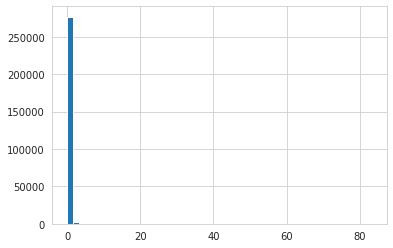

In [25]:
fig, ax = plt.subplots()
ax.hist(combined.gauge_precip.values.flatten(), bins=50)
plt.show()

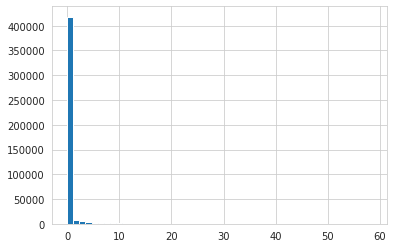

In [15]:
fig, ax = plt.subplots()
ax.hist(combined.HE_precip.values.flatten(), bins=50)
plt.show()

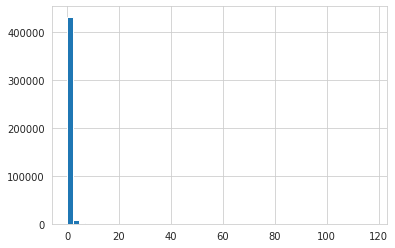

In [16]:
fig, ax = plt.subplots()
ax.hist(combined.HE_precip_corr.values.flatten(), bins=50)
plt.show()

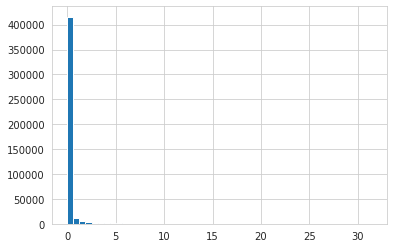

In [17]:
fig, ax = plt.subplots()
ax.hist(combined.xception_posterior_mean.values.flatten(), bins=50)
plt.show()

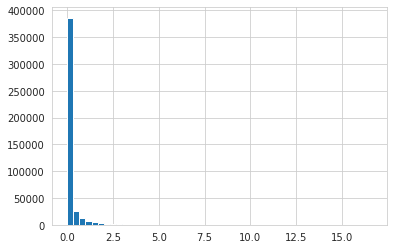

In [18]:
fig, ax = plt.subplots()
ax.hist(combined.mlp_posterior_mean.values.flatten(), bins=50)
plt.show()

### NaNs

In [19]:
np.isnan(combined.HE_precip.values).sum()

6090

In [20]:
np.isnan(combined.xception_posterior_mean.values).sum()

1759

In [21]:
np.isnan(combined.mlp_posterior_mean.values).sum()

1759

In [22]:
isnans = np.isnan(combined.gauge_precip.values).sum()
isnans

165555

In [23]:
alls = len(combined.gauge_precip.values.flatten())
alls

449442

In [24]:
isnans/alls

0.36835676238535786